<a id="cont"></a>

## Table of Contents

<a href=#one>1. Introduction</a>

<a href=#two>2. Importing Packages</a>

<a href=#three>3. Loading Data</a>

<a href=#four>4. Exploratory Data Analysis (EDA)</a>

<a href=#five>5. Data Engineering</a>

<a href=#six>6. Modeling</a>

<a href=#seven>7. Model Performance</a>

<a href=#eight>8. Model Explanations</a>

 <a id="one"></a>
## 1. Introduction
<a href=#cont>Back to Table of Contents</a>

**Project Overview**

After decades receiving little attention from non-scientists, the impacts of climate change are now widely discussed through a variety of mediums. Originating from scientific papers, newspaper articles, and blog posts, a broad spectrum of climate change opinions, subjects, and sentiments exist. Newspaper articles often dismiss or sensationalize the effects of climate change due to journalistic biases including personalization, dramatization and a need for novelty. Scientific papers portray a much more realistic and consensus view of climate change. These views, however, do not receive widespread media attention due to several factors including journal paywalls, formal scientific language, and technical results that are not easy for the general public to understand. 

In the last decade, there has been a shift from the consumption of traditional mass media (newspapers and broadcast television) to the consumption of social media (blog posts, Twitter, etc.). This shift represents a switch in communications from “one-to-many” to “many-to-many”. Rather than a single journalist or scientist telling the public exactly what to think, social media offers a mechanism for many people of diverse backgrounds to communicate and form their own opinions. Exposure is a key aspect in transforming a social problem into a public issue, and social media is a potential avenue where climate change issues can be initially exposed.

In this project, we analyze a dataset that aggregates tweets pertaining to climate change collected between Apr 27, 2015 and Feb 21, 2018. In total, we have 43943 tweets.

**Problem Statement**
Build a model that is able to classify a person's sentiment towards climate change based on their novel tweet data.


 <a id="two"></a>
## 2. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In [429]:
# Libraries for data loading, data manipulation and data visulisation
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
from multiprocesspandas import applyparallel
from comet_ml import Experiment

%matplotlib inline
# set plot style
sns.set()

# Libraries for Natural Language processing
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer
from wordcloud import WordCloud
import re
import unicodedata
from nltk.stem.snowball import SnowballStemmer
import contractions

# Libraries for data preparation and model building
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Setting global constants to ensure notebook results are reproducible
SEED = 42

In [368]:
experiment = Experiment(
    api_key="cbtJsKjDivb61gTUBXpeo48r7",
    project_name="classification-predict-streamlit-group3",
    workspace="michael-py",
)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/michael-py/classification-predict-streamlit-group3/2ffb9b28c1e8472ea52b77fff62e2f13
COMET INFO:   Parameters:
COMET INFO:     C                                 : 1.0
COMET INFO:     analyzer                          : word
COMET INFO:     binary                            : False
COMET INFO:     class_weight                      : 1
COMET INFO:     clf                               : LogisticRegression(penalty='l1', random_state=42, solver='liblinear')
COMET INFO:     clf_C                             : 1.0
COMET INFO:     clf__C                            : 1.0
COMET INFO:     clf__class_weight                 : 1
COMET INFO:     clf__dual                         : False
COMET INFO:     clf__fit_intercept                : True
COMET INFO:     clf

COMET INFO:     tokenizer                         : 1
COMET INFO:     tol                               : 0.0001
COMET INFO:     vectorizer                        : CountVectorizer()
COMET INFO:     vectorizer__analyzer              : word
COMET INFO:     vectorizer__binary                : False
COMET INFO:     vectorizer__decode_error          : strict
COMET INFO:     vectorizer__dtype                 : <class 'numpy.int64'>
COMET INFO:     vectorizer__encoding              : utf-8
COMET INFO:     vectorizer__input                 : content
COMET INFO:     vectorizer__lowercase             : True
COMET INFO:     vectorizer__max_df                : 1.0
COMET INFO:     vectorizer__max_features          : 1
COMET INFO:     vectorizer__min_df                : 1
COMET INFO:     vectorizer__ngram_range           : (1, 1)
COMET INFO:     vectorizer__preprocessor          : 1
COMET INFO:     vectorizer__stop_words            : 1
COMET INFO:     vectorizer__strip_accents         : 1
COMET INF

<a id="two"></a>
## 3. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In [369]:
df = pd.read_csv('kaggle_data/train.csv')# loading the data
df_test = pd.read_csv('kaggle_data/test.csv')

<a id="three"></a>
## 4. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

### What is EDA?

In a nutshell, exploratory data analysis (EDA) is what data analysts do with large amounts of data to uncover patterns and summarize the dataset's primary characteristics in addition to what they learn from modeling and hypothesis testing. EDA is a notion in data analytics that allows analysts to approach a database without making any assumptions. When a data analyst employs EDA, it's as if the data is revealing what they don't already know.

In [370]:
# take a peek into the dataset
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


Here we take a quick peek into our loaded dataset and we see that there are __3__ columns of note; `sentiment`, `message` and `tweetid`

A further investigation will provide the dimensions of our dataset, that is looking at the `shape` of the data

In [371]:
df.shape

(15819, 3)

Here, we can see that our dataset is made up of __15,819__ rows and __3__ columns, as was earlier revealed.

Next let's see of all that number of data points in the dataset, how many of them do not contain any data? and what kind of data is contained in each column? These questions will be answered by looking at the information of the dataset provided by the `.info()` method.

In [372]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


The information above tells us that all of the columns in our dataset contain __15,819__ rows of data that are `non-null`, meaning we have no missing values in our dataset. This can be attested to by the information provided when we looked at the `shape` of the data above

Another interesting information to extract from this dataset will be the unique labels in the `sentiment` which is our `label` or `dependent variable`

In [373]:
sentiment_labels = list(df.sentiment.unique())
print(sentiment_labels)

[1, 2, 0, -1]


We have __4__ different labels which make up the list of all possible sentiments that can be predicted by our model(s)

__-1__: means it is a NEGATIVE sentiment
__0__: means it is a NEUTRAL sentiment
__1__: means it is a POSITIVE sentiment
__2__: means it is a FACTUAL sentiment from a reputable News Site

What are the proportions of our dataset that these labels represent? First, we will look at the figures and then we will look at a chart and barplot for better understanding  

In [374]:
labels_proportions = df.sentiment.value_counts()
labels_proportions

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

We can see that _label 1_ is very highly represented (__8,530__) and _label 2_ follows not so closely (__3,640__), which can be a good thing because it indicates that a lot of people are speaking about climate change and are aware of its impacts on our planet. _Label 0_ comes in third (__2,353__); these tweets are neutral, having no connections with climate change or its woes.

Gladly, the negative sentiments come in tops from the bottom (__1,296__). These are tweets from people that do not believe in the reality of climate change or global warming

Now the chart.

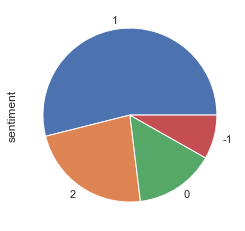

In [375]:
labels_proportions.plot(kind="pie", subplots=True)
plt.xticks(rotation=0)
plt.show()

Here we see that the biggest slice of the pie represents the _positive comments_ followed by the _factual comments/posts_ and so on, confirming what we understand from the figures. This is further demonstrated in the barplot below.

Text(0.5, 1.0, 'Class Distributions')

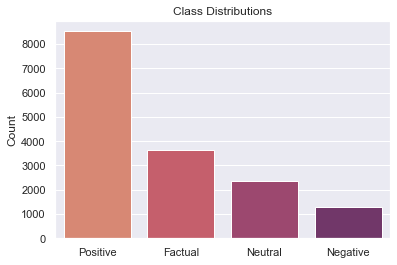

In [376]:
class_distribution = pd.DataFrame(list(df['sentiment'].value_counts()),
                          index=['Positive', 'Factual', 'Neutral', 'Negative'],
                          columns=['Count'])
sns.set()
sns.barplot(x=class_distribution.index, y=class_distribution.Count, 
           palette="flare")
plt.title('Class Distributions')

While we are glad that there are more _positive_ comments than the _neutral_ and _negative_ ones combined, this poses an issue when we try to feed the data into our machine learning algorithm. This is as a result of an __imbalance__ of the proportion of data represented by the labels in our dataset. We will dive into that further in the **data engineering** section; what data imbalance is and how to deal with it.

Out of curiosity, While it is intuitive to spot a _postive_ or a _negative_ or a _neutral_ comment, what makes a comment *factual*? hmm..

Let's look further into the data and see what we find.

We will approach this by printing a sample of messages in these different comment categories and see if we can make sense of what we find.

In [377]:
positives = df['message'][df['sentiment'] == 1]
negatives = df['message'][df['sentiment'] == -1]
neutrals = df['message'][df['sentiment'] == 0]
factuals = df['message'][df['sentiment'] == 2]

print("Positive comments:")
print(f"\t{np.array(positives[:5])}\n")
print("Negative comments:")
print(f"\t{np.array(negatives[:5])}\n")
print("Neutral comments:")
print(f"\t{np.array(neutrals[:5])}\n")
print("Factual comments:")
print(f"\t{np.array(factuals[:5])}\n")

Positive comments:
	["PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable"
 "It's not like we lack evidence of anthropogenic global warming"
 '#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD'
 "RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight"
 "Worth a read whether you do or don't believe in climate change https://t.co/ggLZVNYjun https://t.co/7AFE2mAH8j"]

Negative comments:
	['Sally Kohn’s latest evidence of climate change proves she is ‘not a smart person’ https://t.co/MhkzoGL9Vt via @twitchyteam Need we say more'
 "@realDonaldTrump Carbon Tax is a Globalist idea to enslave the world's population. It is the whole reason for propagating global warming!"
 'RT @SteveSGoddard: We had winds close to 100 MPH in the area this afternoon. I would blame climate change, except that 

At first glance, nothing particularly stands out but looking closely, only factual comments have posts from news sites like **@RawStory** and **@latimes**. A quick research into **@tveitdal** shows that he is a grandmaster in climate change and environmental consultancy, but are we to take his words as facts? hmm.. We will dive into this further during **data engineering**. 

There are no surprises in the _negative_ comments, there's a post with Donald Trump tagged.

There also seems to be a lot of links in these posts. These have to be handled one way or another as they will become "noise" in the data set. In the meantime, let's investigate this further.

**What are the words that are more frequent in each post type**

In [378]:
def words_freq(df, n):
    import string
    stop_words = stopwords.words('english')
    stop_words.append('rt')
    stop_words.append('&amp;')
    dict_ = {}
    for row in np.array(df):
        word_sw = ' '.join([l.lower() for l in row.split(' ') if l.lower() not in stop_words])
        word_punct = ''.join([l for l in word_sw if l not in string.punctuation])

        for wd in word_punct.split(" "):
            if wd in dict_:
                dict_[wd] += 1
            else:
                dict_[wd] = 1
    
    dict_ = {k: v for k,v in sorted(dict_.items(), key=lambda kv: kv[1], reverse=True)}
    n_largest = dict(list(dict_.items())[:n])
    
    return n_largest

In [379]:
pos = words_freq(positives, 60)
print(pos)

{'climate': 7328, 'change': 6873, 'global': 1592, 'warming': 1391, '': 1018, 'believe': 1000, 'trump': 877, 'going': 590, 'real': 469, 'people': 449, 'world': 443, 'us': 437, 'die': 394, 'thinking': 337, 'husband': 312, 'stephenschlegel': 307, 'httpstcosjofonã¢â‚¬â¦': 307, 'fight': 281, 'new': 281, 'like': 272, 'epa': 262, 'hoax': 252, 'sensanders': 248, 'say': 244, 'think': 234, 'need': 233, 'science': 230, 'thinks': 218, 'president': 207, 'https…': 201, 'action': 198, 'donald': 195, 'presidentelect': 192, 'right': 192, 'know': 189, 'planet': 183, 'via': 181, 'denier': 180, 'deniers': 174, 'one': 172, 'scientists': 171, 'realdonaldtrump': 164, 'stop': 164, 'still': 164, 'must': 162, 'make': 159, 'millions': 154, 'future': 154, 'tã¢â‚¬â¦': 153, 'watch': 151, 'chinese': 151, 'mr': 150, 'earth': 149, 'trumps': 147, 'take': 145, 'beforetheflood': 143, 'im': 140, 'time': 140, 'could': 137, 'would': 137}


In [380]:
neg = words_freq(negatives, 60)
print(neg)

{'climate': 781, 'change': 718, 'global': 632, 'warming': 589, '': 165, 'science': 74, 'realdonaldtrump': 68, 'us': 62, 'real': 59, 'trump': 57, 'people': 56, 'man': 52, 'would': 50, 'hoax': 50, 'scam': 49, 'made': 47, 'manmade': 46, 'data': 45, 'believe': 45, 'stevesgoddard': 44, 'make': 42, 'years': 42, 'like': 41, 'obama': 40, 'gore': 40, 'news': 35, 'al': 35, 'scientists': 35, 'money': 35, 'one': 33, 'fake': 33, 'cause': 33, 'world': 33, 'know': 32, 'tax': 31, 'chinese': 31, 'liberals': 30, 'think': 29, 'scientist': 28, 'good': 28, 'going': 28, 'left': 28, 'created': 28, 'it': 28, 'weather': 28, 'order': 27, 'leaders': 27, 'say': 26, 'due': 26, 'concept': 26, 'caused': 26, 'ice': 26, 'get': 25, 'manufacturing': 25, 'stop': 25, 'hell': 25, 'time': 24, 'manipulated': 24, 'https…': 23, 'noncompetitive': 23}


In [381]:
neu = words_freq(neutrals, 60)
print(neu)

{'climate': 1428, 'change': 1340, 'global': 1032, 'warming': 948, '': 276, 'trump': 147, 'us': 100, 'like': 96, 'real': 93, 'believe': 87, 'penguin': 84, 'think': 81, 'im': 80, 'hes': 77, 'people': 65, 'cause': 55, 'know': 52, 'one': 49, 'says': 45, 'get': 45, 'club': 44, 'new': 44, 'said': 44, 'would': 43, 'hot': 43, 'good': 39, 'world': 39, 'thing': 39, 'need': 37, 'care': 37, 'thats': 36, 'great': 36, 'right': 36, 'weather': 36, 'still': 35, 'going': 34, 'really': 34, 'want': 34, 'say': 33, 'even': 33, 'talk': 33, 'time': 32, 'much': 31, 'stop': 31, 'man': 30, 'realdonaldtrump': 30, 'hoax': 30, 'leonardo': 30, 'tell': 30, 'make': 30, 'science': 29, 'asked': 28, 'u': 28, 'today': 28, 'epa': 28, 'it': 27, 'cant': 27, 'cold': 26, 'what': 26, 'see': 26}


In [382]:
fact = words_freq(factuals, 60)
print(fact)

{'climate': 3324, 'change': 3100, 'trump': 825, '': 677, 'global': 503, 'warming': 418, 'us': 290, 'via': 286, 'says': 240, 'epa': 235, 'new': 190, 'scientists': 175, 'trumps': 165, 'donald': 162, 'fight': 158, 'china': 142, 'could': 133, 'news': 121, 'world': 113, 'scott': 112, 'paris': 110, 'chief': 100, 'energy': 100, 'president': 100, 'study': 97, 'pruitt': 96, 'science': 94, 'may': 93, 'plan': 88, 'thehill': 82, 'agreement': 79, 'carbon': 78, 'cnn': 78, 'exxon': 78, 'head': 76, 'obama': 76, 'environment': 73, 'https…': 72, 'tillerson': 71, 'house': 69, 'report': 69, 'change…': 68, 'reuters': 67, 'un': 66, 'website': 64, 'order': 64, 'back': 64, 'climatechange': 63, 'trump’s': 63, 'say': 62, 'guardian': 62, 'years': 59, 'due': 59, 'rex': 58, 'leaders': 58, 'dioxide': 56, 'white': 55, 'government': 55, 'arctic': 55, 'action': 55}


#### - *words that make a comment factual*

In [383]:
Negative = list(set(neg.keys()) - set(list(fact.keys()) + list(pos.keys()) + list(neu.keys())))

Positive = list(set(pos.keys()) - set(list(fact.keys()) + list(neg.keys()) + list(neu.keys())))

Neutral = list(set(neu.keys()) - set(list(fact.keys()) + list(pos.keys()) + list(neg.keys())))

Factual = list(set(fact.keys()) - set(list(neg.keys()) + list(pos.keys()) + list(neu.keys())))


In [384]:
def word_cloud(data, sentiment):
    # Create a variable to store the text
   
    text = " ".join(word for word in data)
    # Instantiate wordcloud object
    word_cloud = WordCloud(collocations =False,
                          background_color = 'White',
                          width=400, 
                          height=300, 
                          contour_width=2, 
                          contour_color='steelblue')
    # generate wordcloud images
    word_cloud.generate(text)
    # Create Plot
    
    plt.figure(figsize =(10,10))
    plt.imshow(word_cloud, interpolation ='bilinear' )
    plt.axis('off')
    plt.title('Most Frequent Words in sentiment {}'.format(sentiment), size = 25, pad =15)
    plt.show()

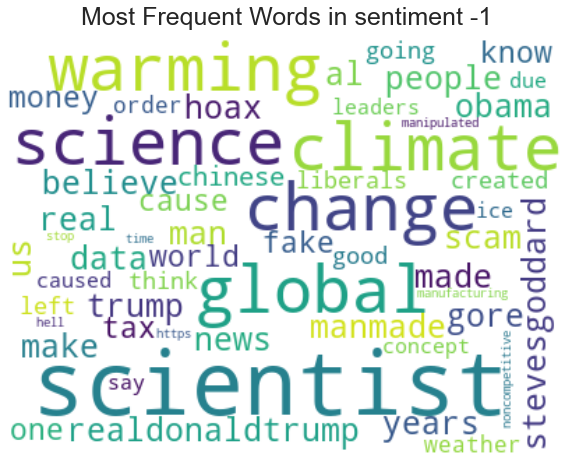

In [385]:
word_cloud(neg, -1)

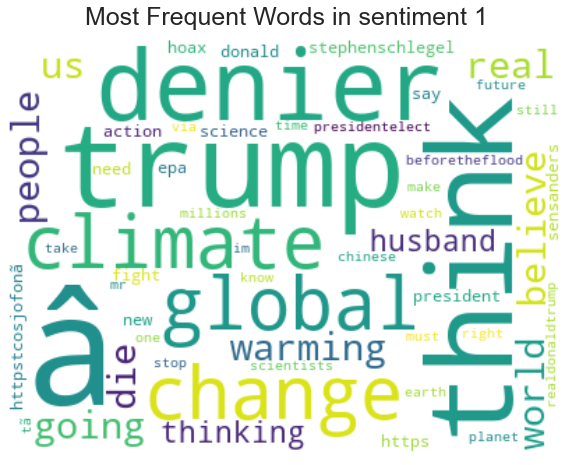

In [386]:
word_cloud(pos, 1)

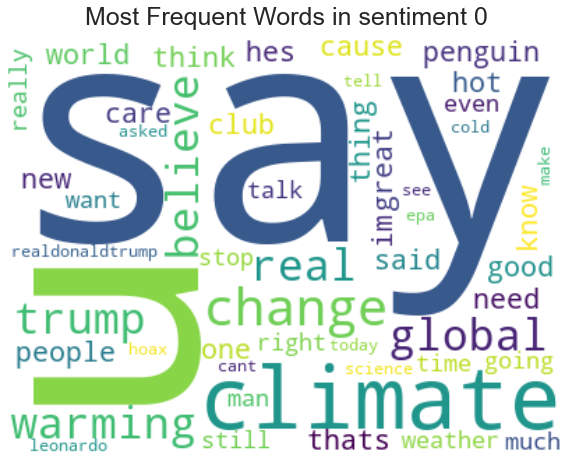

In [387]:
word_cloud(neu, 0)

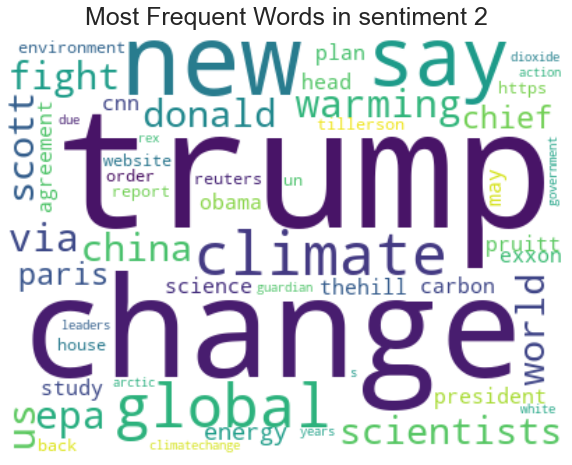

In [388]:
word_cloud(fact, 2)

So far we've taken a look at what the most frequent words are per sentiment and have seen how factual comments differ from other comments after taking a look at the top 20 frequent words. A few words of interest are "epa", "news", "scientists" and "via" which all tend to be words use in a news site publication

**Note**, our data is still a bit noisy because we haven't taken care of the urls in each post yet and there's a lot of non-english words. But this gives us an idea.

**How many links are there in total? and How are they shared amongst the sentiments?**

In [389]:
# how many links there are
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
urls = []
for row in df['message']:
    match = re.findall(pattern_url, row)
    for item in match:
        urls.append(item)

total_links = len(urls)
print(total_links)

9673


Here we see that there are __9,673__ url links in the dataset.

In [390]:
# Number of links per sentiment

# copy dataframe to not change structure of main df
df_copy = df.copy()

# create new column `url
url = []

# find urls per row 
for row in df_copy['message']:
    match = re.findall(pattern_url, row)
    url.append(len(match)) # append the number of urls found per row
    
df_copy['url'] = url

df_copy.head()

,sentiment,message,tweetid,url
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,1
1,1,It's not like we lack evidence of anthropogeni...,126103,0
2,2,RT @RawStory: Researchers say we have three ye...,698562,2
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,1
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,0


In [391]:
maxf = max(list(df_copy.url))

df_copy[df_copy.url == maxf]

,sentiment,message,tweetid,url
2754,2,https://t.co/u4R1BqQ5UR | Parliament ratifies ...,104560,3
3233,2,https://t.co/B2Fk05gnwC Forbidden phrases at U...,954879,3
5715,2,Cloudy feedback on global warming - https://t....,659920,3
8297,1,RT @zoeschlanger: The https://t.co/O90Lo4IhlO ...,67703,3
9131,2,How climate change may drive extreme weather -...,338028,3
11256,2,RT @NaturePlants: Predicting rice yield losses...,273452,3


In [392]:
count_dict = {}

for l in df_copy.sentiment.unique():
    new_df = df_copy[df_copy.sentiment == l]
    count_dict[l] = sum(new_df.url)
    
count_dict

{1: 4199, 2: 4070, 0: 865, -1: 539}

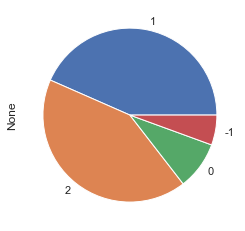

In [393]:
pd.Series(count_dict).plot(kind='pie')
plt.xticks(rotation=0)
plt.show()

Again, _positive_ and _factual_ comments lead the way, indicating that there may be more to gain from these urls, particularly in the case of the _factual_ comments which has more **urls** than it does **data points** (__4,070 :__ __3640__). This is by no means conclusive. 

Perhaps the model will tell us more eventually.

### Twitter Handles

A Twitter handle is the username that appears at the end of a unique Twitter URL. Twitter handles appear after the @ sign in the profile URL and it must be unique to a user account. A Twitter name, on the other hand, is simply there to help people find the company they’re looking for.

Let's see if we can get any information from the twitter handles in our data.

In [394]:
# Creating a function to extract handles from tweets
def extract_handles(x):
    handles = []
    for i in x:
        h = re.findall(r'@(\w+)', i)
        handles.append(h)
        
    return handles

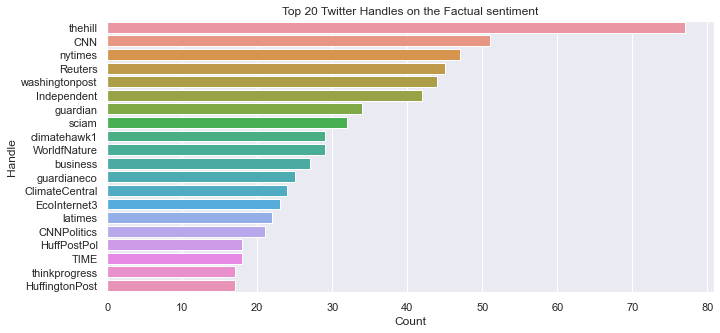

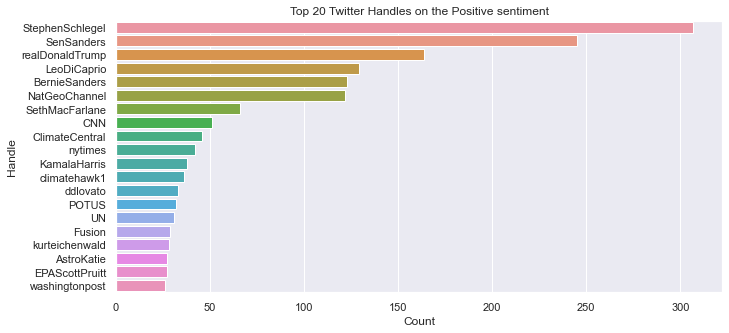

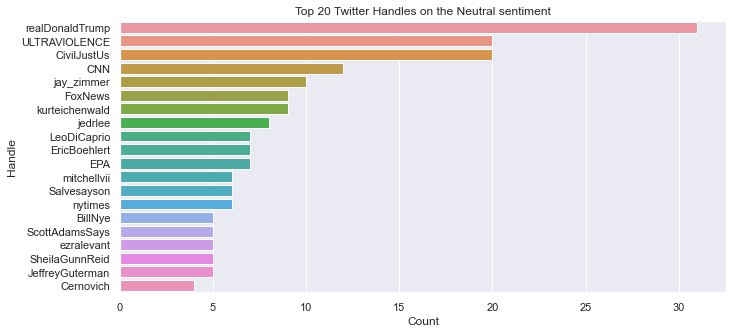

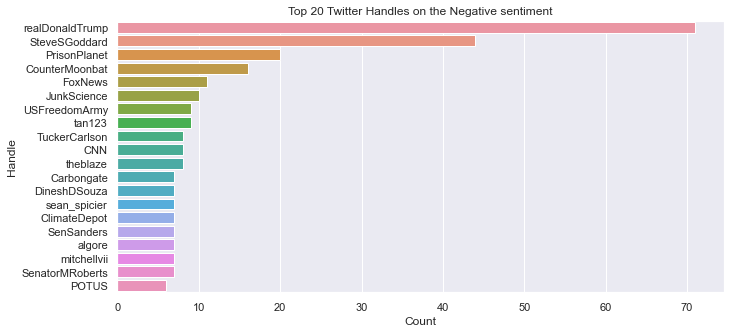

In [395]:
Factual = extract_handles(df_copy['message']
                              [df_copy['sentiment'] == 2])
Positive = extract_handles(df_copy['message']
                          [df_copy['sentiment'] == 1])
Neutral = extract_handles(df_copy['message']
                              [df_copy['sentiment'] == 0])
Negative = extract_handles(df_copy['message']
                          [df_copy['sentiment'] == -1])

# handle lists 
handles = [sum(Factual, []), sum(Positive, []), sum(Neutral, []),
           sum(Negative, [])]

# Visualising the Handles
full_title = ['Top 20 Twitter Handles on the Factual sentiment',
              'Top 20 Twitter Handles on the Positive sentiment',
              'Top 20 Twitter Handles on the Neutral sentiment',
              'Top 20 Twitter Handles on the Negative sentiment']

plt.rcParams['figure.figsize'] = [50, 5]

for i, sent in enumerate(handles):
    plt.subplot(1, 4, i + 1)
    freq_dist = nltk.FreqDist(sent)
    df = pd.DataFrame({'Handle': list(freq_dist.keys()),
                      'Count' : list(freq_dist.values())})

    df = df.nlargest(columns='Count', n=20)

    ax = sns.barplot(data=df, y='Handle', x='Count')
    plt.title(full_title[i])
    plt.show()

From the above visuals we can see that:
- The factual handles are real life News outlets
- Donald Trump is a leading voice in Neutral and Negative sentiments
- Politicians and celebrities take the biggest chunck of the positive sentiment
    

### Hashtags

On Twitter, adding a “#” to the beginning of an unbroken word or phrase creates a hashtag. When you use a hashtag in a Tweet, it becomes linked to all of the other Tweets that include it.People use the hashtag symbol (#) before a relevant keyword or phrase in their Tweet to categorize those Tweets and help them show more easily in Twitter search. Clicking or tapping on a hashtagged word in any message shows you other Tweets that include that hashtag. Hashtags can be included anywhere in a Tweet.

Let's look at what the hashtags in our data will tell us.

In [396]:
# Function to extract hashtags from the tweets

def extract_hashtags(x):
    hashtags = []
    for i in x:
        ht = re.findall(r'#(\w+)', i)
        hashtags.append(ht)
        
    return hashtags

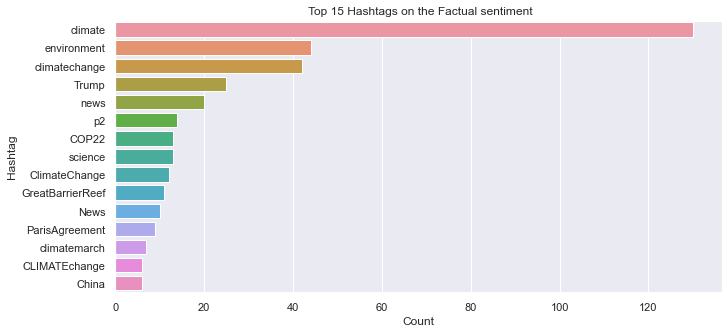

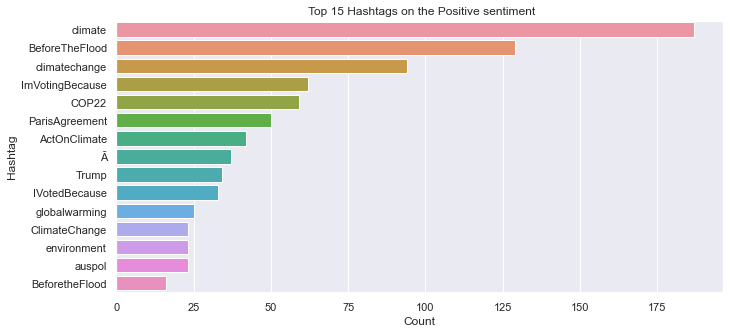

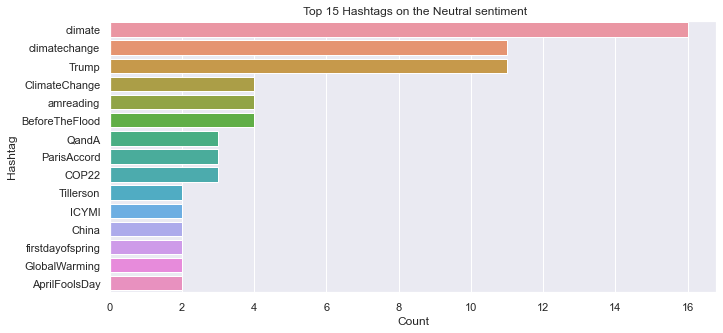

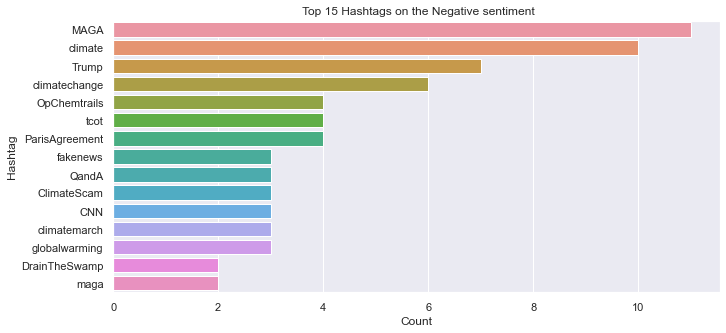

In [397]:
# Extracting hashtags from tweets
Factual = extract_hashtags(df_copy['message']
                              [df_copy['sentiment'] == 2])
Positive = extract_hashtags(df_copy['message']
                          [df_copy['sentiment'] == 1])
Neutral = extract_hashtags(df_copy['message']
                              [df_copy['sentiment'] == 0])
Negative = extract_hashtags(df_copy['message']
                          [df_copy['sentiment'] == -1])

# List of hashtags
hashtags = [sum(Factual, []), sum(Positive, []),
            sum(Neutral, []),sum(Negative, [])]

# Visualising the Hashtags
ht_titles = [' Top 15 Hashtags on the Factual sentiment',
              ' Top 15 Hashtags on the Positive sentiment',
              ' Top 15 Hashtags on the Neutral sentiment',
              ' Top 15 Hashtags on the Negative sentiment']

plt.rcParams['figure.figsize'] = [50, 5]

for i, sent in enumerate(hashtags):
    plt.subplot(1, 4, i + 1)
    freq_dist = nltk.FreqDist(sent)
    df = pd.DataFrame({'Hashtag': list(freq_dist.keys()),
                      'Count' : list(freq_dist.values())})

    df = df.nlargest(columns='Count', n=15)

    ax = sns.barplot(data=df, y='Hashtag', x='Count')
    plt.title(ht_titles[i])
    plt.show()

### Cleaning up The Data

We will write a function to clean up our data to remove the noise that could affect our model's perfomance when we finally get there. In this next step we will:

 - Remove punctuations
 
 - Remove hashtags
 
 - Remove twitter handles
 
 - Remove urls
 
 - Remove non-english words
 
 - Remove emojis
 
 - Remove white spaces. 

In [398]:
#Removing the contractions for both the train and Train DataFrames
#Remove contractions on Train Dataset
df_copy['message'] = df_copy['message'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df_copy['message'] = [' '.join(map(str, l)) for l in df_copy['message']]

#Remove Contractions on Test Dataset
df_test['message'] = df_test['message'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df_test['message'] = [' '.join(map(str, l)) for l in df_test['message']]

df_copy.head()

,sentiment,message,tweetid,url
0,1,PolySciMajor EPA chief does not think carbon d...,625221,1
1,1,It is not like we lack evidence of anthropogen...,126103,0
2,2,RT @RawStory: Researchers say we have three ye...,698562,2
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,1
4,1,"RT @SoyNovioDeTodas: It is 2016, and a racist,...",466954,0


In [399]:
def clean_data (tweet):
    """    
    Input is datatype 'str': tweet (noisy tweet)
    
    Output is datatype 'str': tweet (cleaned tweet)
    """
    #convert to lowercase
    tweet = tweet.lower()
    
    #remove punctuation
    tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", ' ', tweet)
    
    #remove hashtags
    tweet = re.sub(r'#\w*','', tweet)
    
    #remove mentions 
    tweet = re.sub('@[\w]*','',tweet)
    
    #remove urls
    tweet = re.split('https:\/\/.*', str(tweet))[0]
    
    #remove emojis 
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emojis
        u"\U0001F300-\U0001F5FF"  # symbols 
        u"\U0001F680-\U0001F6FF"  # maps
        u"\U0001F1E0-\U0001F1FF"  # flags
                           "]+", flags = re.UNICODE)
    tweet = regrex_pattern.sub(r'', tweet)    
    
    #remove numbers 
    tweet = re.sub(r'\d+','', tweet)    
    
    #remove acsii
    tweet = unicodedata.normalize('NFKD', tweet).encode('ascii', 'ignore').decode('utf-8')
    
    #remove extra whitespaces 
    tweet = re.sub(r'\s\s+', ' ', tweet)
    
    #remove space in front of tweet
    tweet = tweet.lstrip(' ')
    
    return tweet

In [400]:
df_copy['message'] = df_copy['message'].replace(to_replace=r'^https?:\/\/.*[\r\n]*',value='',regex=True)
df_test['message'] = df_test['message'].replace(to_replace=r'^https?:\/\/.*[\r\n]*',value='',regex=True)                                               

We now pass our train and test dataframes through the clean_data function.

In [401]:
df_copy['message'] = df_copy['message'].apply(clean_data) #train data
df_test['message'] = df_test['message'].apply(clean_data) #test data

In [402]:
df_copy.head()

,sentiment,message,tweetid,url
0,1,polyscimajor epa chief does not think carbon d...,625221,1
1,1,it is not like we lack evidence of anthropogen...,126103,0
2,2,rt rawstory researchers say we have three year...,698562,2
3,1,todayinmaker wired was a pivotal year in the w...,573736,1
4,1,rt soynoviodetodas it is and a racist sexist c...,466954,0


### Analysing our data after cleaning up

In [403]:
positives = df_copy['message'][df_copy['sentiment'] == 1]
negatives = df_copy['message'][df_copy['sentiment'] == -1]
neutrals = df_copy['message'][df_copy['sentiment'] == 0]
factuals = df_copy['message'][df_copy['sentiment'] == 2]

pos_clean = words_freq(positives, 60)
neg_clean = words_freq(negatives, 60)
neu_clean = words_freq(neutrals, 60)
fact_clean = words_freq(factuals, 60)


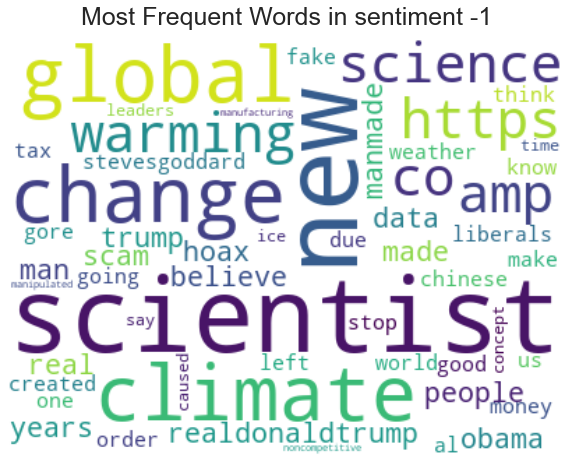

In [404]:
word_cloud(neg_clean,-1)

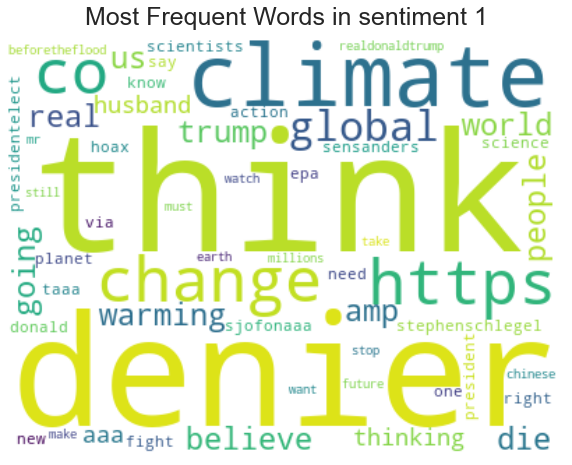

In [405]:
word_cloud(pos_clean,1)

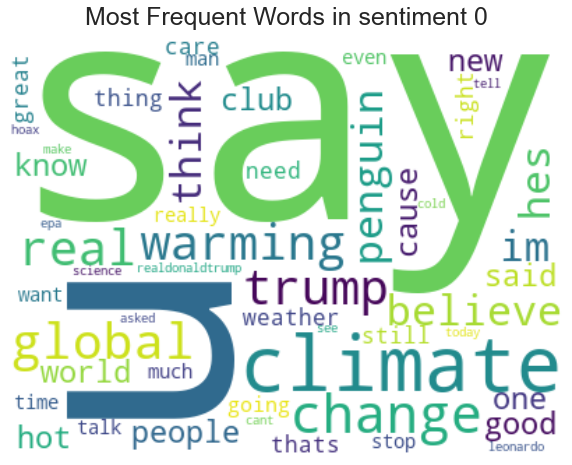

In [406]:
word_cloud(neu,0)

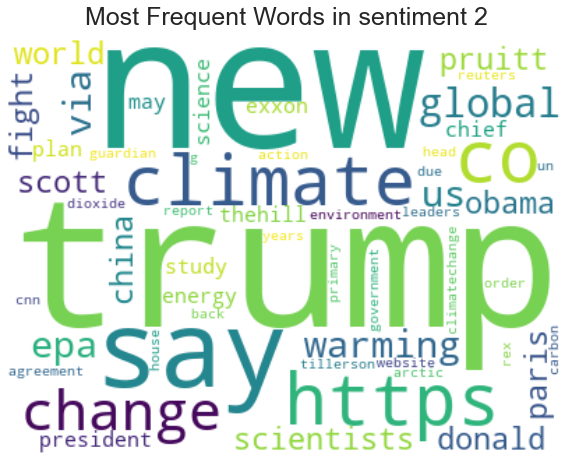

In [407]:
word_cloud(fact_clean,2)

<a id="four"></a>
## 5. Data Engineering


### What is Data Engineering?

Data engineering is the process of creating features that allow machine learning algorithms to work utilizing domain knowledge of the data. Feature engineering is both difficult and expensive, but it is essential to the application of machine learning.

#### The Problem With Text Data

A major problem with *text* data is that it is very messy and requires a lot of cleaning. In addition to that, it comes in a form that will be very difficult to feed into our machine learning models and get meaningful results, if any for that matter.

A machine learning model only understands numbers in form of `ints` and `floats` and has a difficult time comprehending what alphabets represent.

To help our machine learn better and make its life more bearable, we will need to transform our text data into digits in such a way that translates what the text is to the machine in numbers, thereby retaining, up to level, the meanings of the text. To do this, we will be carrying out a concept called `Data Engineering`.

`Data Engineering` has been referred to a couple of times so far in this notebook, let's find out what it is next

In [408]:
tokeniser = TreebankWordTokenizer()
df_copy['tokenized'] = df_copy['message'].apply(tokeniser.tokenize)
df_test['tokenized'] = df_test['message'].apply(tokeniser.tokenize)

In [409]:
df_copy.head()

,sentiment,message,tweetid,url,tokenized
0,1,polyscimajor epa chief does not think carbon d...,625221,1,"[polyscimajor, epa, chief, does, not, think, c..."
1,1,it is not like we lack evidence of anthropogen...,126103,0,"[it, is, not, like, we, lack, evidence, of, an..."
2,2,rt rawstory researchers say we have three year...,698562,2,"[rt, rawstory, researchers, say, we, have, thr..."
3,1,todayinmaker wired was a pivotal year in the w...,573736,1,"[todayinmaker, wired, was, a, pivotal, year, i..."
4,1,rt soynoviodetodas it is and a racist sexist c...,466954,0,"[rt, soynoviodetodas, it, is, and, a, racist, ..."


In [410]:
stemmer = SnowballStemmer('english')
df_copy['stemmed'] = df_copy['tokenized'].apply(lambda x: [stemmer.stem(y) for y in x])
df_test['stemmed'] = df_test['tokenized'].apply(lambda x: [stemmer.stem(y) for y in x])

In [411]:
df_copy.head()

,sentiment,message,tweetid,url,tokenized,stemmed
0,1,polyscimajor epa chief does not think carbon d...,625221,1,"[polyscimajor, epa, chief, does, not, think, c...","[polyscimajor, epa, chief, doe, not, think, ca..."
1,1,it is not like we lack evidence of anthropogen...,126103,0,"[it, is, not, like, we, lack, evidence, of, an...","[it, is, not, like, we, lack, evid, of, anthro..."
2,2,rt rawstory researchers say we have three year...,698562,2,"[rt, rawstory, researchers, say, we, have, thr...","[rt, rawstori, research, say, we, have, three,..."
3,1,todayinmaker wired was a pivotal year in the w...,573736,1,"[todayinmaker, wired, was, a, pivotal, year, i...","[todayinmak, wire, was, a, pivot, year, in, th..."
4,1,rt soynoviodetodas it is and a racist sexist c...,466954,0,"[rt, soynoviodetodas, it, is, and, a, racist, ...","[rt, soynoviodetoda, it, is, and, a, racist, s..."


In [355]:
X = df_copy['message']
y = df_copy['sentiment']

X_token = df_copy['tokenized']

X_stem = df_copy['stemmed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

X_train_token, X_test_token, y_train_token, y_test_token = train_test_split(X_token, y, test_size=0.2, random_state = 42)

X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem, y, test_size=0.2, random_state = 42)

In [421]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

#Logistic Regression
lr = Pipeline([('tfidf', TfidfVectorizer(sublinear_tf=True, 
                                         smooth_idf = True, 
                                         max_df = 0.3,
                                         ngram_range = (1, 2),
                                         stop_words='english')),
               ('clf', LogisticRegression(random_state=123, 
                                          multi_class='ovr',
                                          n_jobs=1, 
                                          C=1e5,
                                          max_iter = 4000))])
    
    
    
#Multinomial Naive Bayes
multi = Pipeline([('tfidf', TfidfVectorizer(sublinear_tf=True, 
                                            smooth_idf = True, 
                                            max_df = 0.3,
                                            ngram_range = (1, 2),
                                            stop_words='english')),
                  ('clf', MultinomialNB())])
    
    
    
#Random Forest Classifier
rf = Pipeline([('tfidf', TfidfVectorizer(sublinear_tf=True, 
                                         smooth_idf = True, 
                                         max_df = 0.3,
                                         ngram_range = (1, 2),
                                         stop_words='english')),
               ('clf', RandomForestClassifier(n_estimators=100, 
                                              max_depth=2, 
                                              random_state=0, 
                                              class_weight="balanced"))])
    
    
#Support Vector Classifier
svc = Pipeline([('tfidf', TfidfVectorizer(sublinear_tf=True, 
                                          smooth_idf = True, 
                                          max_df = 0.3,
                                          ngram_range = (1, 2),
                                          stop_words='english')),
                ('clf', SVC(gamma = 0.8, 
                            C = 10, 
                            random_state=42))])
    
    
    
#Linear SVC
linsvc = Pipeline([('tfidf', TfidfVectorizer(sublinear_tf=True, 
                                             smooth_idf = True, 
                                             max_df = 0.3,
                                             ngram_range = (1, 2),
                                             stop_words='english')),
                   ('clf', LinearSVC())])
    
    
    
#K Nearest Neighbours Classifier
kn = Pipeline([('tfidf', TfidfVectorizer(sublinear_tf=True, 
                                         smooth_idf = True, 
                                         max_df = 0.3,
                                         ngram_range = (1, 2),
                                         stop_words='english')),
               ('clf', KNeighborsClassifier(n_neighbors=3))])
    
    
    
#Decision Tree Classifier
dt = Pipeline([('tfidf', TfidfVectorizer(sublinear_tf=True, 
                                         smooth_idf = True, 
                                         max_df = 0.3,
                                         ngram_range = (1, 2),
                                         stop_words='english')),
               ('clf', DecisionTreeClassifier(random_state=42))])


### Training the Models

In [422]:
# Logistic regression
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Multinomial Naive Bayes
multi.fit(X_train, y_train)
y_pred_multi = multi.predict(X_test)

# Random Forest Classifier
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Support Vector Classifier
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

# Linear SVC
linsvc.fit(X_train, y_train)
y_pred_linsvc = linsvc.predict(X_test)

# K Nearest Neighbours Classifier
kn.fit(X_train, y_train)
y_pred_kn = kn.predict(X_test)

# Decision Tree Classifier
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

COMET ERROR: Failed to extract parameters from estimator


### Evaluating our models' perfomance

In [430]:
f1_score (lr,X_test, y_pred_lr)

C:\Users\Dorcas Oduor\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=[1 2 1 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


TypeError: Expected sequence or array-like, got <class 'sklearn.pipeline.Pipeline'>

### Training

In [356]:
lr = LogisticRegression()

In [357]:
lr.fit(X_train, y_train)
lr.fit(X_train, y_train)
lr.fit(X_train, y_train)

ValueError: could not convert string to float: '[ aljazeera english hdlivestream]climate so is innovative technology to tackle climate change https t co ewhmnmba'

<a id="six"></a>
## 7. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [ ]:
# Compare model performance
import warnings
warnings.filterwarnings('ignore')
classification = classification_report(y_test, y_pred, target_names=['-1', '0', '1', '2'])

print(classification)

In [224]:
# Choose best model and motivate why it is the best choice

classification = classification_report(y_test, rfc_pred, target_names=['-1', '0', '1', '2'])

print(classification)

              precision    recall  f1-score   support

          -1       0.32      0.15      0.20       219
           0       0.41      0.25      0.31       461
           1       0.67      0.78      0.72      1759
           2       0.60      0.62      0.61       725

    accuracy                           0.62      3164
   macro avg       0.50      0.45      0.46      3164
weighted avg       0.59      0.62      0.60      3164



In [225]:
test = pd.read_csv('kaggle_data/test.csv')

In [226]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [227]:
test_x = vector.fit_transform(test.message).toarray()

In [228]:
pred_y = rfc.predict(test_x)

In [229]:
pred_y

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [230]:
#baseline submission

In [231]:
submission_sample = pd.read_csv('kaggle_data/sample_submission.csv')

In [232]:
submission_sample.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [233]:
y_pred

array([ 1, -1,  1, ...,  1,  0,  1], dtype=int64)

In [234]:
sub_file = submission_sample.copy()

In [235]:
sub_file.tweetid = test.tweetid

In [236]:
sub_file.sentiment= pred_y

In [237]:
sub_file.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


In [238]:
sub_file.to_csv("baseline.csv", index=False)

In [239]:
submission_sample.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,1


<a id="seven"></a>
## 8. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>


In [ ]:
# discuss chosen methods logic